In [103]:
import os
import nibabel as nib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import ndimage

plt.rcParams['figure.figsize'] = [20, 10]

In [40]:
path = "ScanManTrain61_knee_data/train/"
label_keys = ["FemoralCartilage",
              "LateralFemoralCartilage",
              "LateralMeniscus",
              "LateralTibialCartilage",
              "MedialFemoralCartilage",
              "MedialMeniscus",
              "MedialTibialCartilage",
              "PatellarCartilage",
              "Tibia"]

In [41]:
img = nib.load(path + "images/img_0.nii.gz").get_fdata()
label = nib.load(path + "labels/img_0.nii.gz").get_fdata()

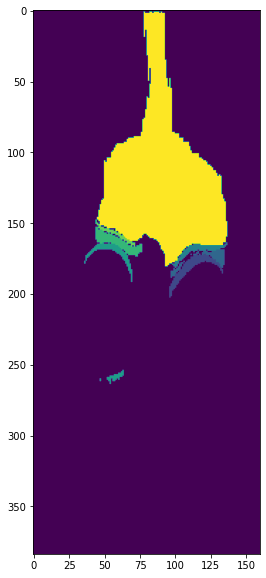

In [148]:
plt.imshow(label[:, 140, : ]) 

In [46]:
def get_class_mask(mask, c):
    return (mask == c).astype(int)

In [75]:
np.sum(get_class_mask(label, 1))

0

In [160]:
def bbox(img):
    # Flatten image along first axis to get bounding box for the two remaining axes
    flat_img = np.max(img, axis=0)
    
    ws = np.any(flat_img, axis=1)
    ds = np.any(flat_img, axis=0)
    wmin, wmax = np.where(ws)[0][[0, -1]]
    dmin, dmax = np.where(ds)[0][[0, -1]]

    return wmin, wmax, dmin, dmax

def center_of_mass(img):
    h, w, d = img.shape
    total = img.sum()
    h_coord = (img.sum(axis=1).sum(axis=1) @ np.arange(h)) / total
    w_coord = (img.sum(axis=2).sum(axis=0) @ np.arange(w)) / total
    d_coord = (img.sum(axis=1).sum(axis=0) @ np.arange(d)) / total
    return np.array([h_coord, w_coord, d_coord])

def BelowCenter(mask, show = False):
    [xs, ys, zs] = np.nonzero(mask) # # coordinates are head->toe, front->back, left-right
    X = np.concatenate((xs.reshape(-1,1), ys.reshape(-1,1)),axis=1)
    pca = PCA(n_components=1)
    pca.fit(X)
    mainDir = pca.components_[0]
    mainDir /= np.linalg.norm(mainDir)
    upDir = np.array([mainDir[1], -mainDir[0]])
    meanX = np.mean(xs) # Axial, head->toe
    meanY = np.mean(ys) # Coronal, front->back
    sz = mask.shape
    for x in range(sz[0]):
        for y in range(sz[1]):
            d = np.array([x - meanX, y - meanY])
            up = np.dot(d,upDir)
            if up>0:
                mask[x,y,:] = 0
    return mainDir, upDir, meanX, meanY  # dont need to return, mask is changed inplace

def extract_compartments(mask):
    label_keys = ["FemoralCartilage",
                  "LateralFemoralCartilage",
                  "LateralMeniscus",
                  "LateralTibialCartilage",
                  "MedialFemoralCartilage",
                  "MedialMeniscus",
                  "MedialTibialCartilage",
                  "PatellarCartilage",
                  "Tibia"]
    # Compartments
    lateral_tibial = get_class_mask(mask, 4)
    medial_tibial = get_class_mask(mask, 7)
    femoral = get_class_mask(mask, 2) + get_class_mask(mask, 5)
    lateral_meniscus = get_class_mask(mask, 3)
    medial_meniscus = get_class_mask(mask, 6)
    
    # Crop femoral cartilage to tibial cartilage bounding box
    lt_wmin, lt_wmax, lt_dmin, lt_dmax = bbox(lateral_tibial)
    mt_wmin, mt_wmax, mt_dmin, mt_dmax = bbox(medial_tibial)
    
    femoral_crop = np.zeros_like(femoral)
    femoral_lt_bbox = femoral[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1]
    femoral_mt_bbox = femoral[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1]
    femoral_crop[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1] = femoral[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1]
    femoral_crop[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1] = femoral[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1]
    
    # PCA cut
    # TODO replace with own version of BelowCenter instead of Lærke's
    BelowCenter(femoral_crop)
    

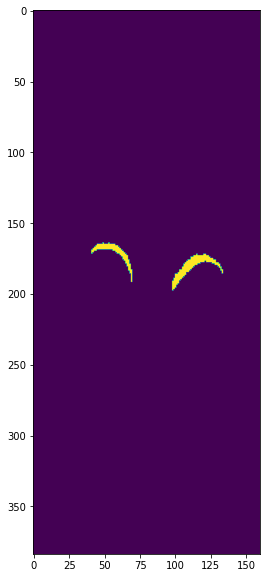

In [161]:
extract_compartments(label)